In [1]:
import control
import matplotlib
import numpy as np
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)
import matplotlib.pyplot as plt

$$G(s) = \dfrac{K}{s(0.1s+1)(s+1)}$$
$K_v = 4 \text{ sec}^{-1}$; $PM>45^\degree$; $GM\geq8\text{ dB}$
$$K=4\text{ sec}^{-1}$$
$$G(s) = \dfrac{4}{0.1s^3+1.1s^2+s}$$

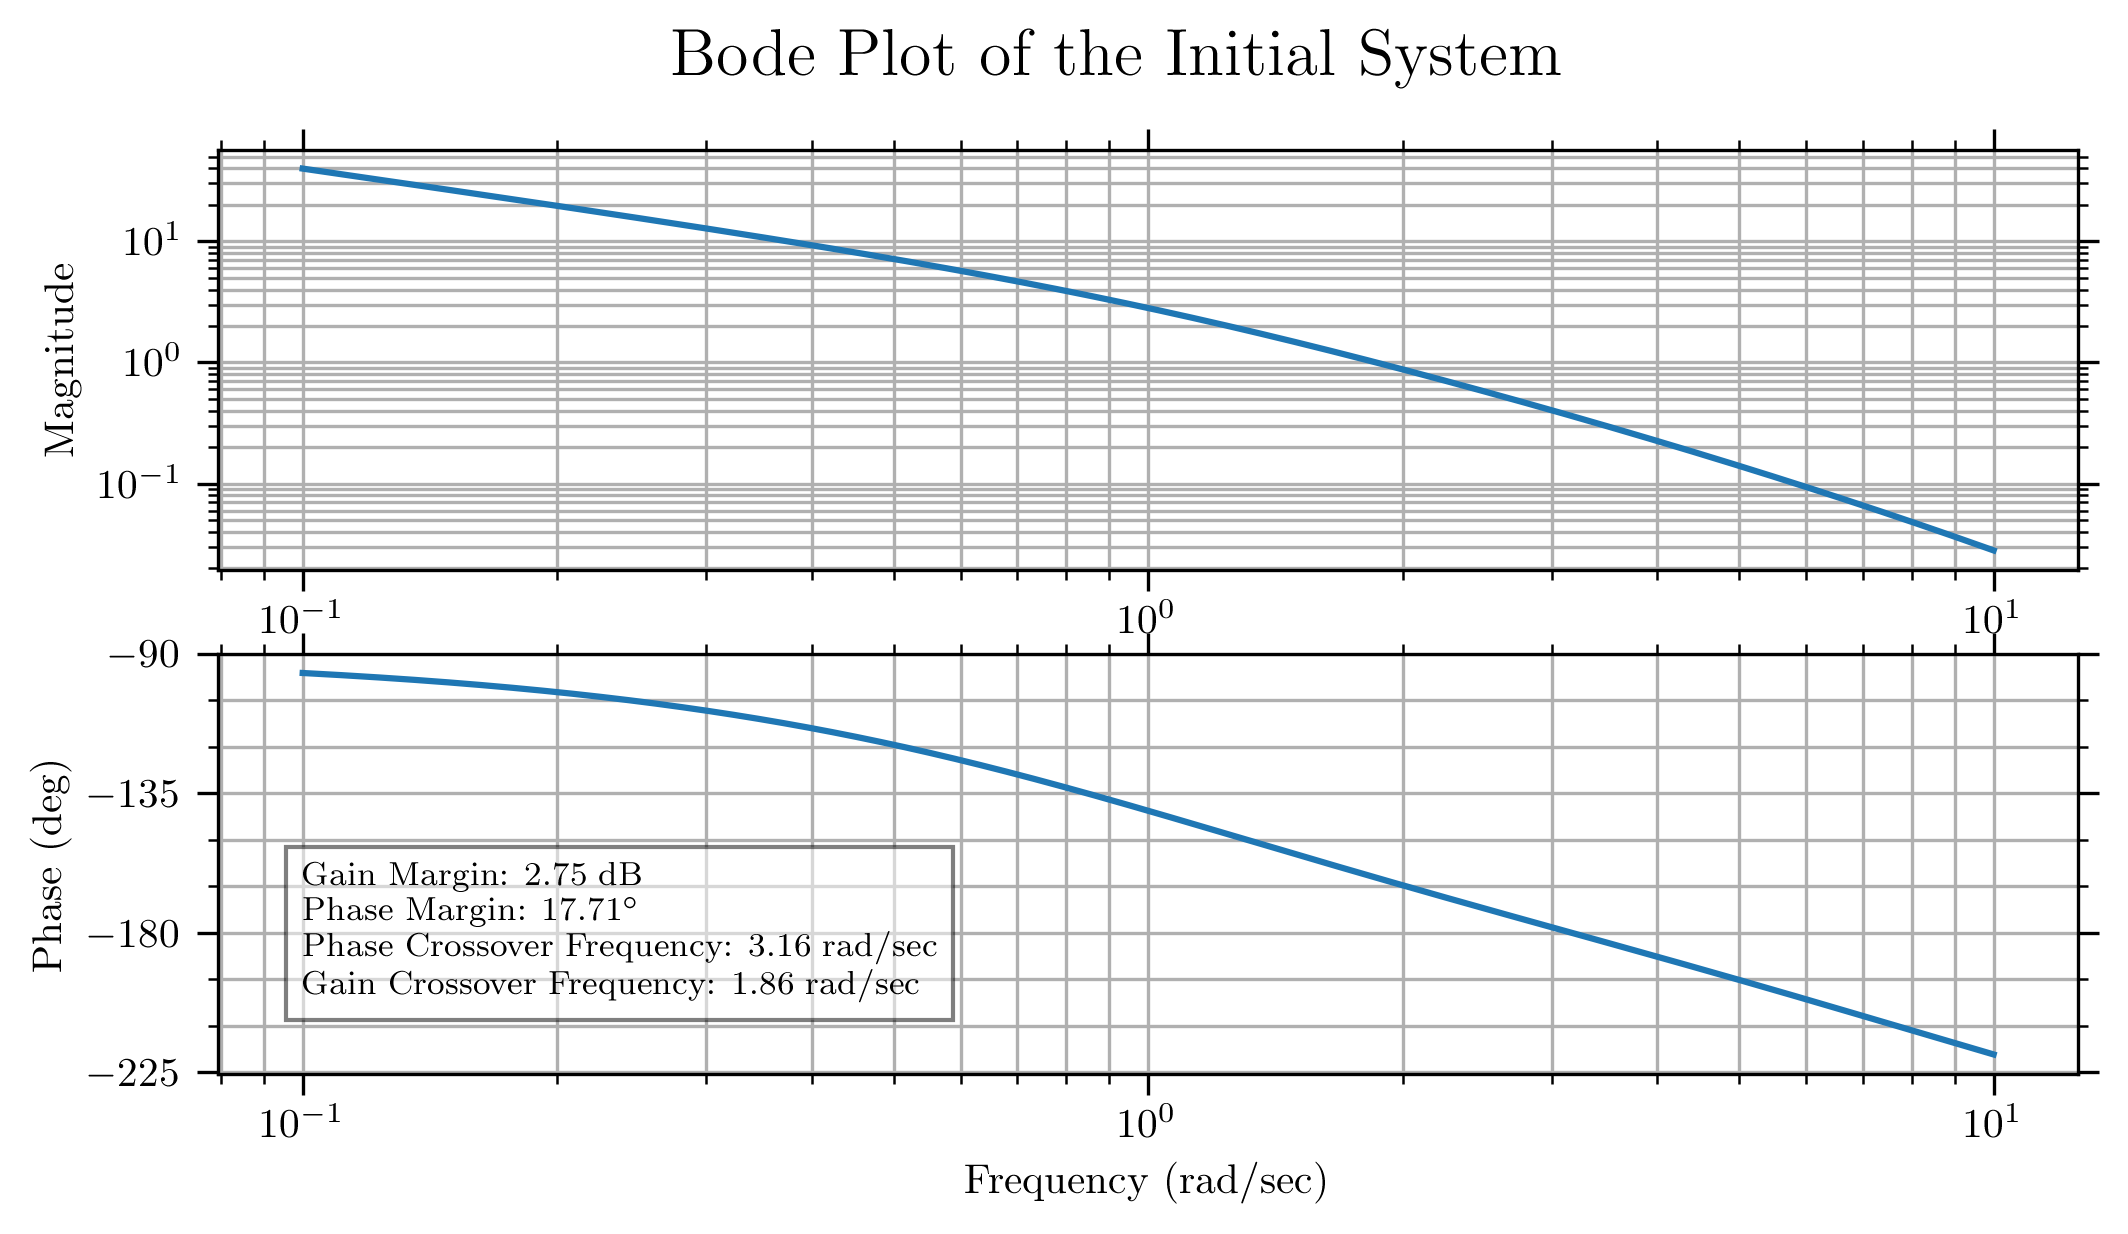

In [58]:
K = 4 #sec^(-1)
G = control.tf([K], [0.1, 1.1, 1, 0])
plt.figure(figsize=(8, 4), dpi=300)
w = np.logspace(-1, 1, 100000)
mag, phase, omega = control.bode(G, w)
gm, pm, wcg, wcp = control.margin(G)
plt.text(0.1, -200, f'Gain Margin: {gm:.2f} dB\nPhase Margin: {pm:.2f}$^\circ$\nPhase Crossover Frequency: {wcg:.2f} rad/sec\nGain Crossover Frequency: {wcp:.2f} rad/sec', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))
plt.suptitle('Bode Plot of the Initial System', fontsize=16)
plt.savefig('bode_uncompensated.png', dpi=300)
plt.show()

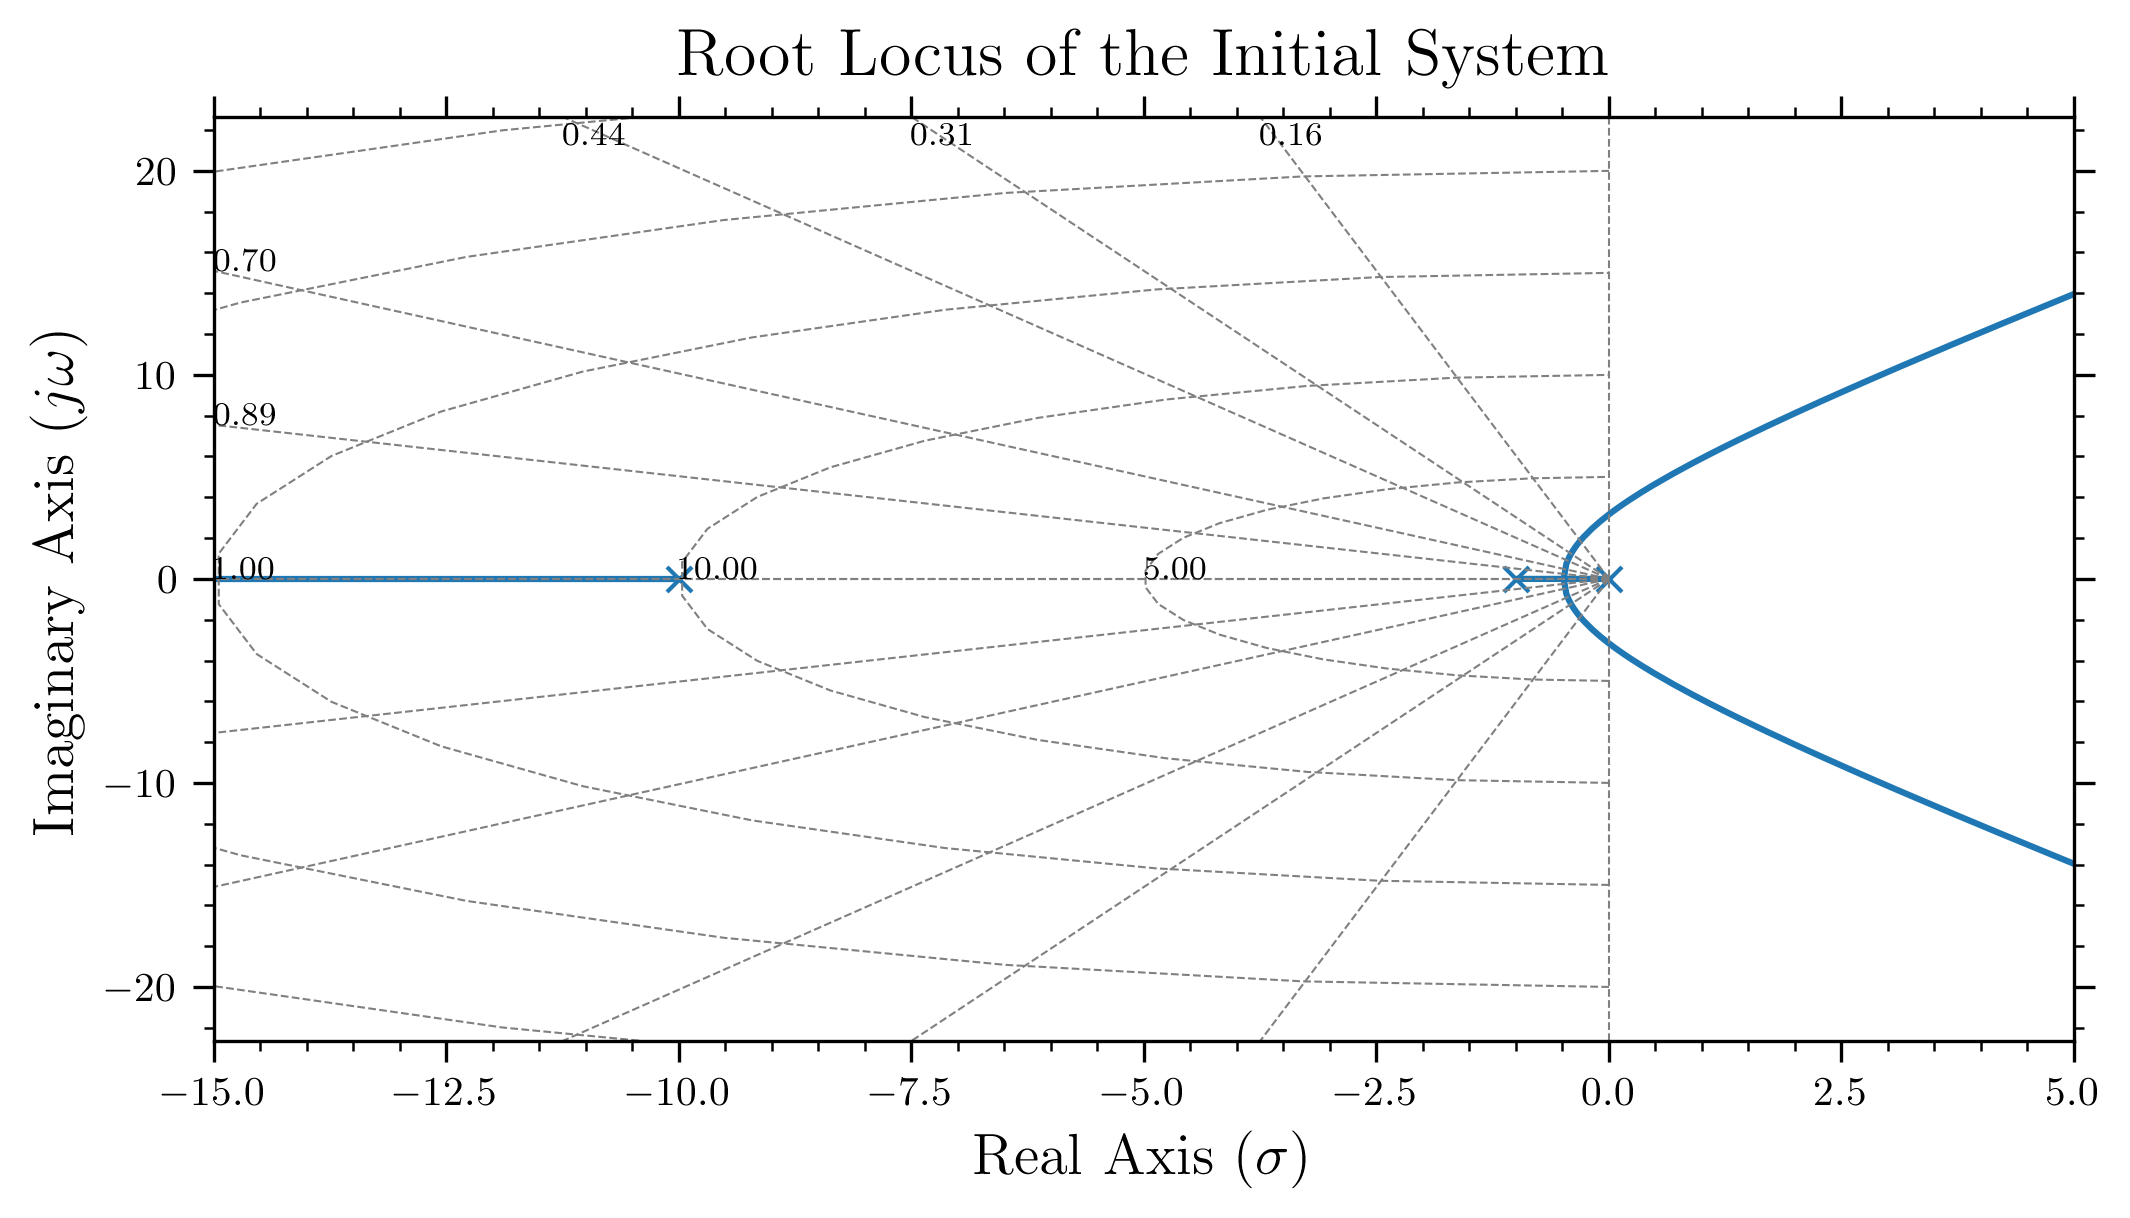

In [66]:
plt.figure(figsize=(8, 4), dpi=300)
roots, gains = control.root_locus(G, xlim=(-15, 5))
plt.title('Root Locus of the Initial System', fontsize=16, pad=10)
plt.xlabel('Real Axis ($\sigma$)', fontsize=14)
plt.ylabel('Imaginary Axis ($j\omega$)', fontsize=14)
plt.savefig('rootlocus_uncompensated.png', dpi=300)

$$G_c(s) = \dfrac{a\tau s+1}{\tau s+ 1}$$
$$\phi_c = \tan^{-1}{a\omega\tau} - \tan^{-1}{\omega\tau}$$
$$\omega_{max} = \dfrac{1}{T\sqrt{a}}$$
$$\phi_{\text{max}} = \sin^{-1}\left(\dfrac{1-a}{1+a}\right)$$
$$|G_c(j\omega_{max})| =\sqrt{a}$$

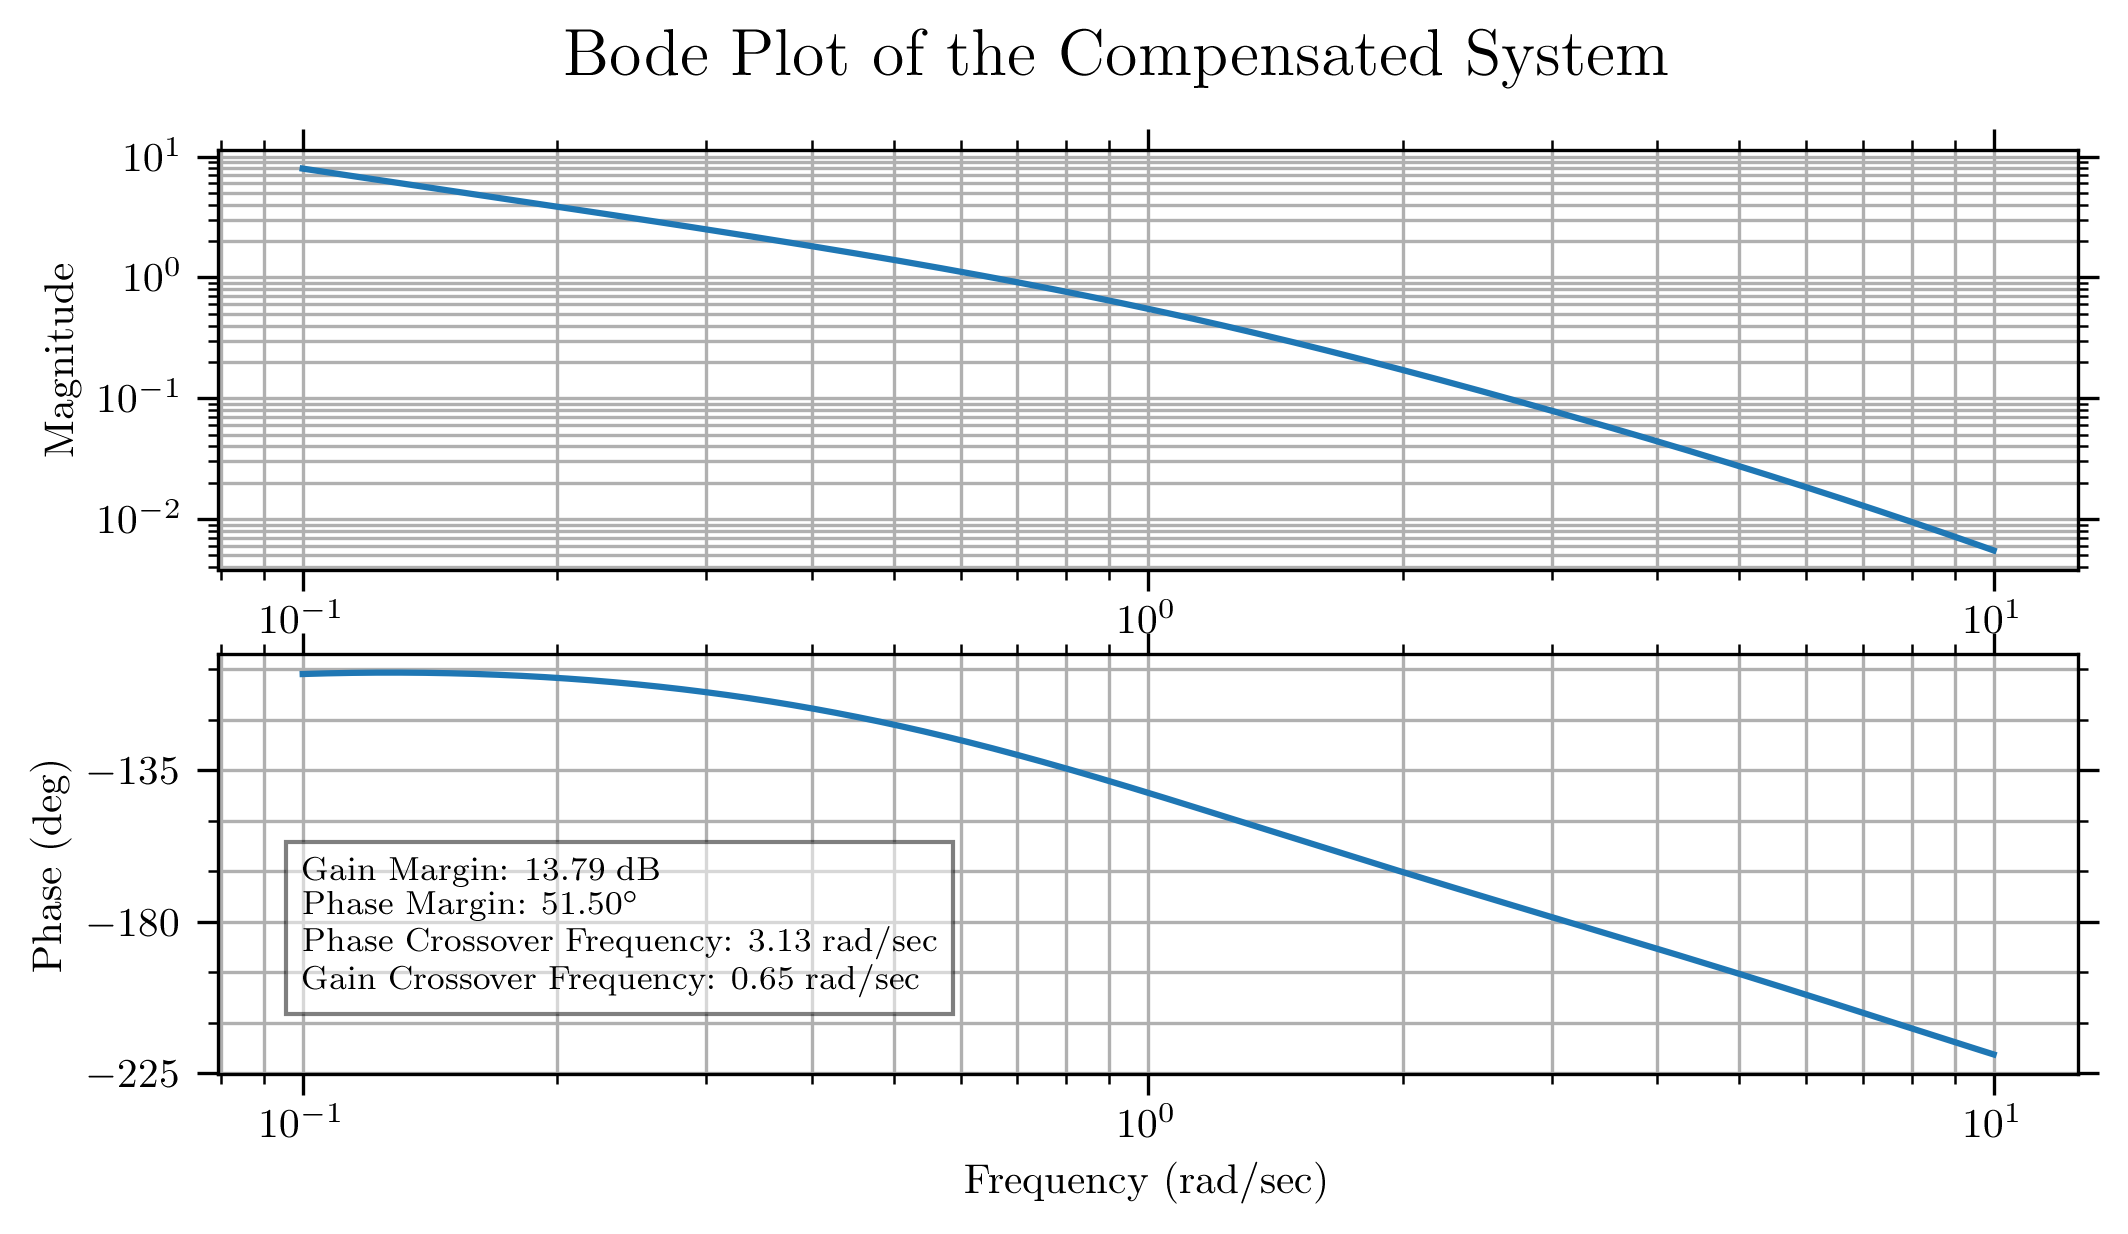

In [62]:
w_gco = omega[phase*180/np.pi>-120][0]/10
phi_max = 60 - pm
a = (1-np.sin(np.deg2rad(phi_max)))/(1+np.sin(np.deg2rad(phi_max)))
T = 1/(w_gco*np.sqrt(a))
G_c = control.tf([a*T, 1], [T, 1])
fig = plt.figure(figsize=(8, 4), dpi=300)
mag, phase, omega = control.bode(G_c*G, w)
gm, pm, wcg, wcp = control.margin(G_c*G)
plt.text(0.1, -200, f'Gain Margin: {gm:.2f} dB\nPhase Margin: {pm:.2f}$^\circ$\nPhase Crossover Frequency: {wcg:.2f} rad/sec\nGain Crossover Frequency: {wcp:.2f} rad/sec', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))
plt.suptitle('Bode Plot of the Compensated System', fontsize=16)
plt.savefig('bode_compensated.png', dpi=300)
plt.show()

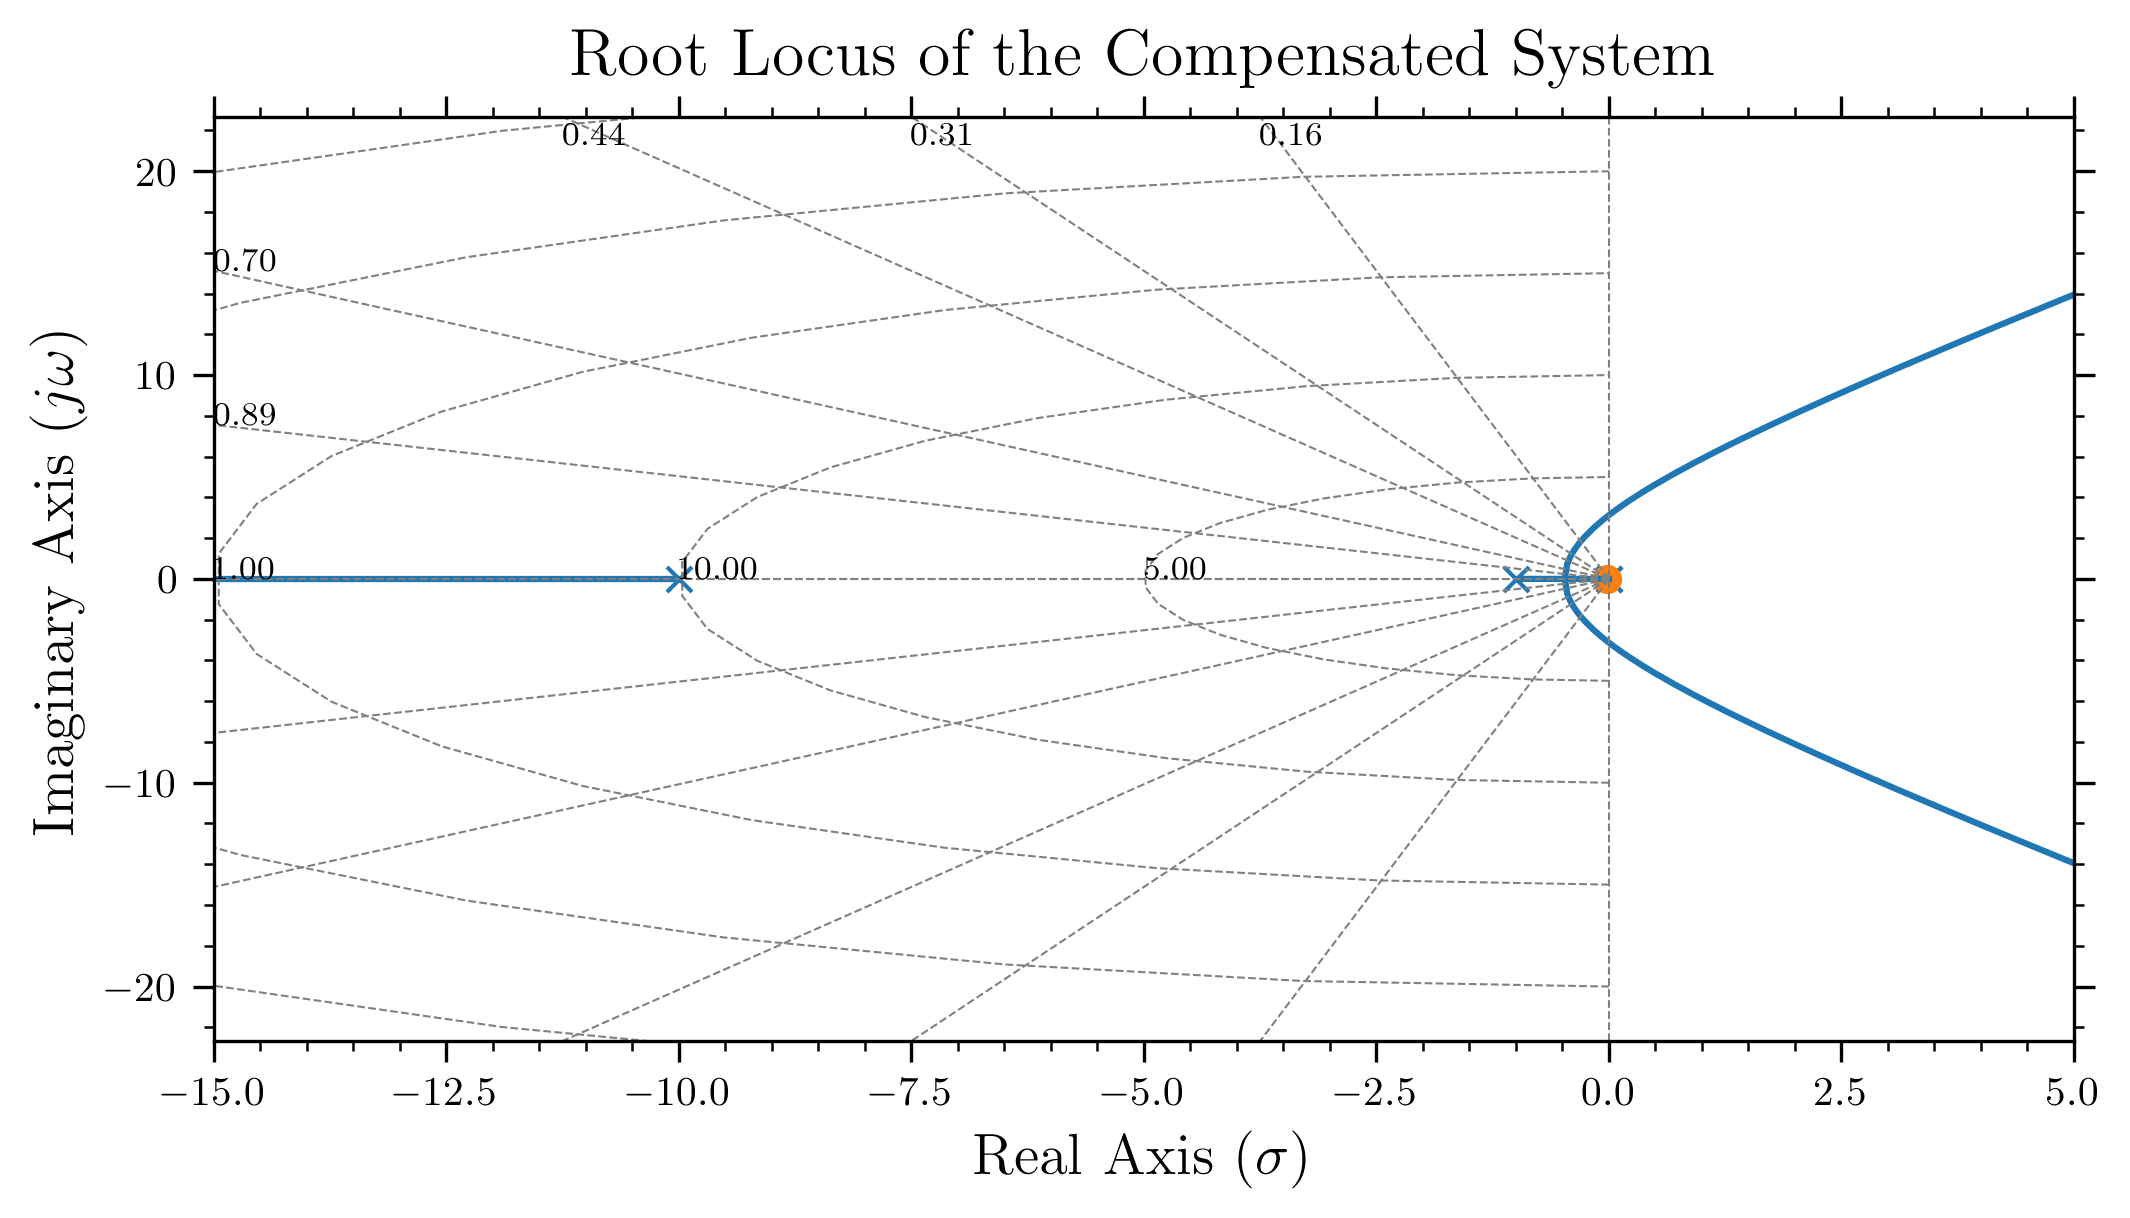

In [67]:
plt.figure(figsize=(8, 4), dpi=300)
roots, gains = control.root_locus(G_c*G, xlim=(-15, 5))
plt.title('Root Locus of the Compensated System', fontsize=16, pad=10)
plt.xlabel('Real Axis ($\sigma$)', fontsize=14)
plt.ylabel('Imaginary Axis ($j\omega$)', fontsize=14)
plt.savefig('rootlocus_compensated.png', dpi=300)
plt.show()

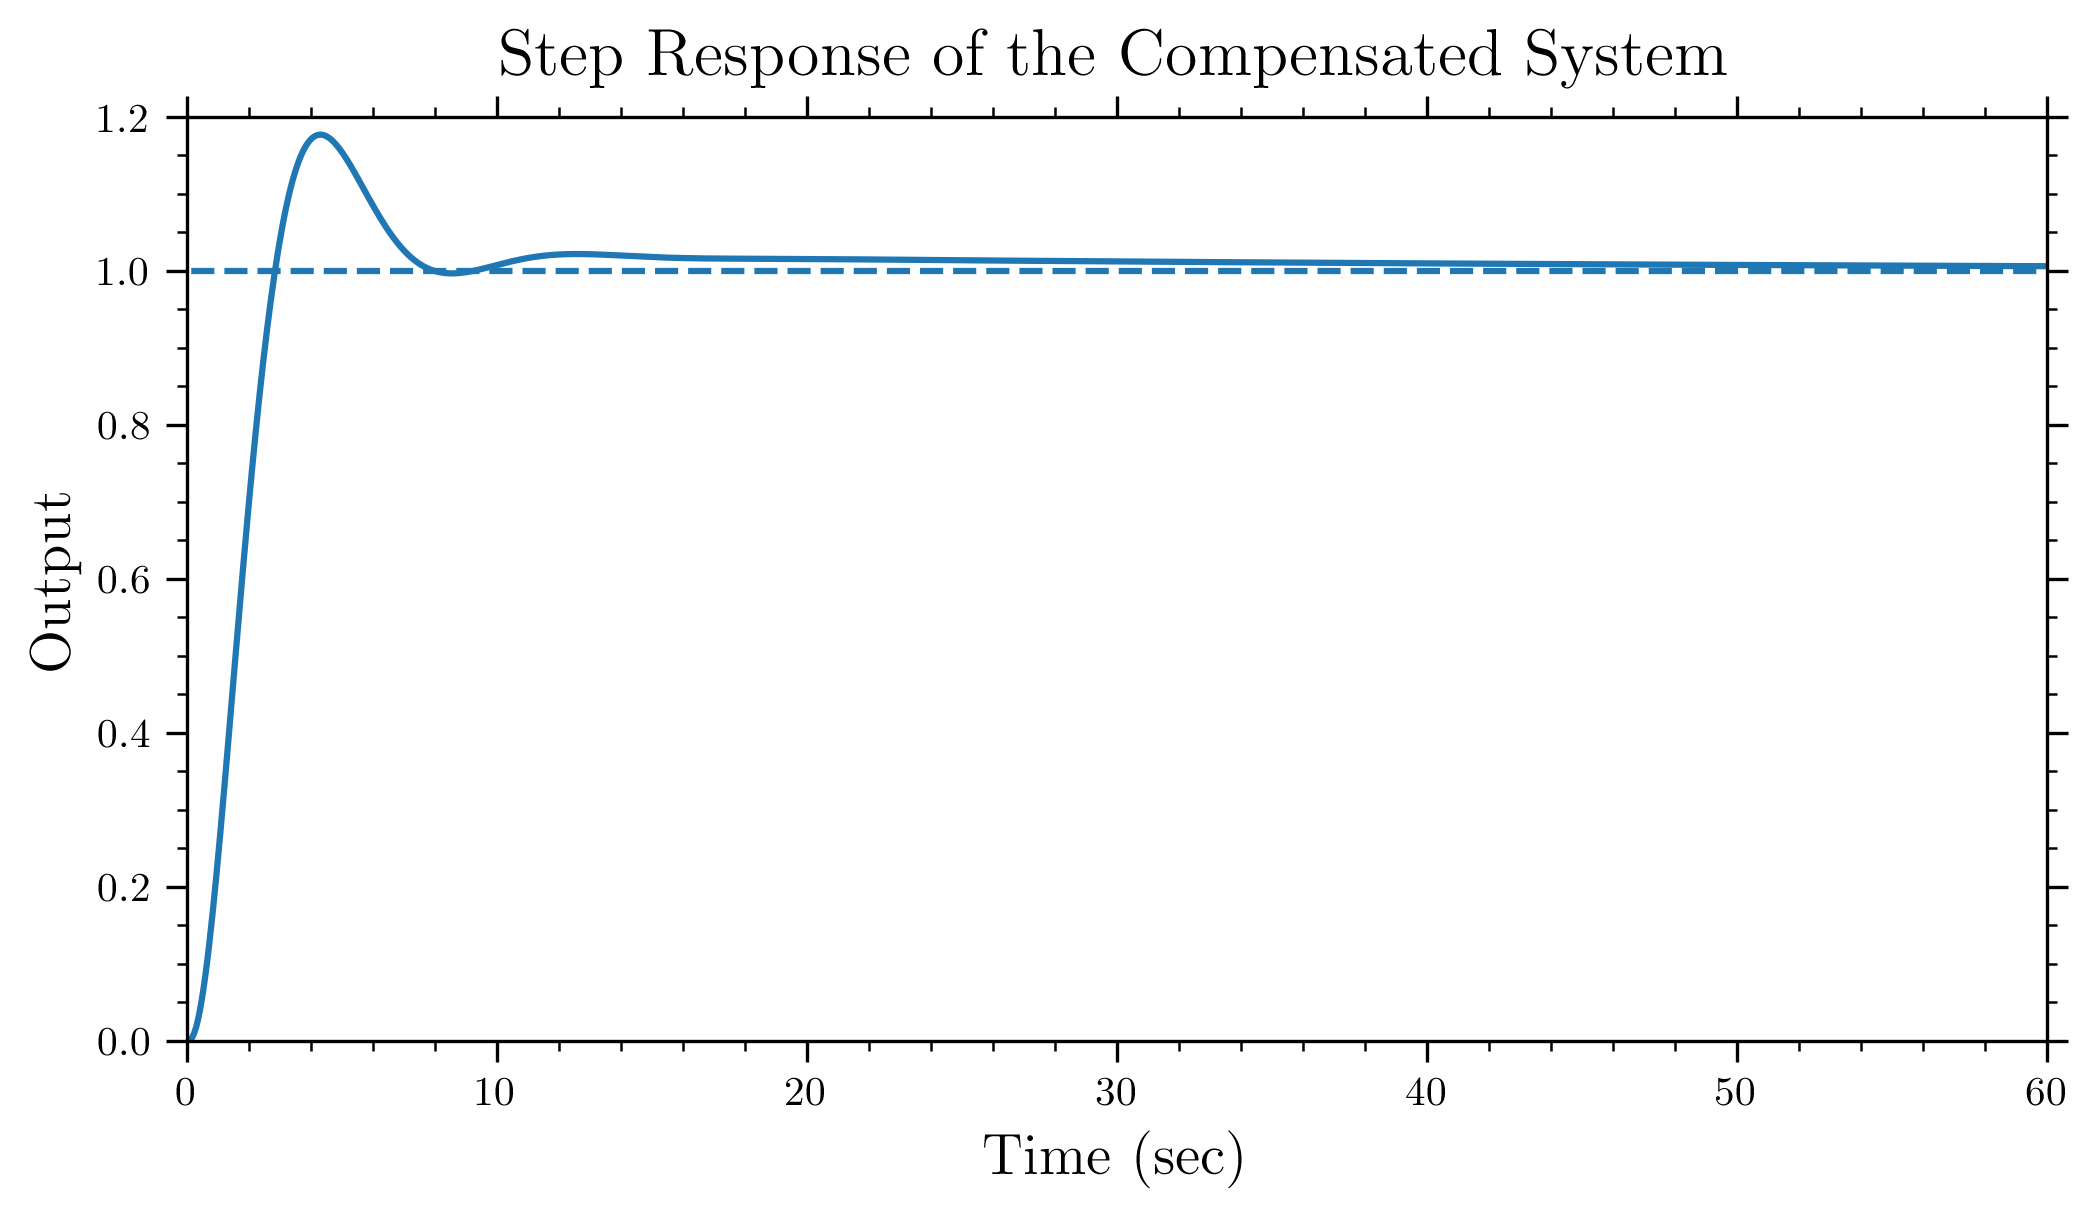

In [76]:
closed_loop_tf = control.feedback(G_c*G, 1)
t = np.linspace(0, 60, 1000)
t, y = control.step_response(closed_loop_tf, t)
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(t, y)
plt.hlines(1, -2, 70, linestyle='dashed')
plt.title('Step Response of the Compensated System', fontsize=16, pad=10)
plt.xlim(0, 60)
plt.ylim(0, 1.2)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('Output', fontsize=14)
plt.savefig('step_response.png', dpi=300)
plt.show()

**Compensator**:
$$G_c(s) = \dfrac{44.21s+1}{226.2s+1}$$

In [44]:
phi_max = np.linspace(20, 90.0001, 100)
w_c = np.linspace(1e-17, 0.1, 100)
gm_array = np.zeros((len(w_c), len(phi_max)))
pm_array = np.zeros((len(w_c), len(phi_max)))
os_array = np.zeros((len(w_c), len(phi_max)))
Ts_array = np.zeros((len(w_c), len(phi_max)))
ess_array = np.zeros((len(w_c), len(phi_max)))
integ = control.tf([1], [1, 0])

counter = 1
for (i, w) in enumerate(w_c):
    for (j, phi) in enumerate(phi_max):
        a = (1-np.sin(np.deg2rad(phi)))/(1+np.sin(np.deg2rad(phi)))
        T = 1/(w*np.sqrt(a))
        G_c = control.tf([a*T, 1], [T, 1])
        gm, pm, *_ = control.margin(G*G_c)
        gm_array[i][j] = gm
        pm_array[i][j] = pm
        # print(counter)
        counter += 1
        if gm>8 and pm>45:
            try:
                closed_loop_tf = control.feedback(G*G_c, 1)
                _, Ts, _, _, os, *_ =  control.step_info(closed_loop_tf).values()
            except:
                os = 0
                Ts = 0
            os_array[i][j] = os
            Ts_array[i][j] = Ts

phi_max, w_c = np.meshgrid(phi_max, w_c)

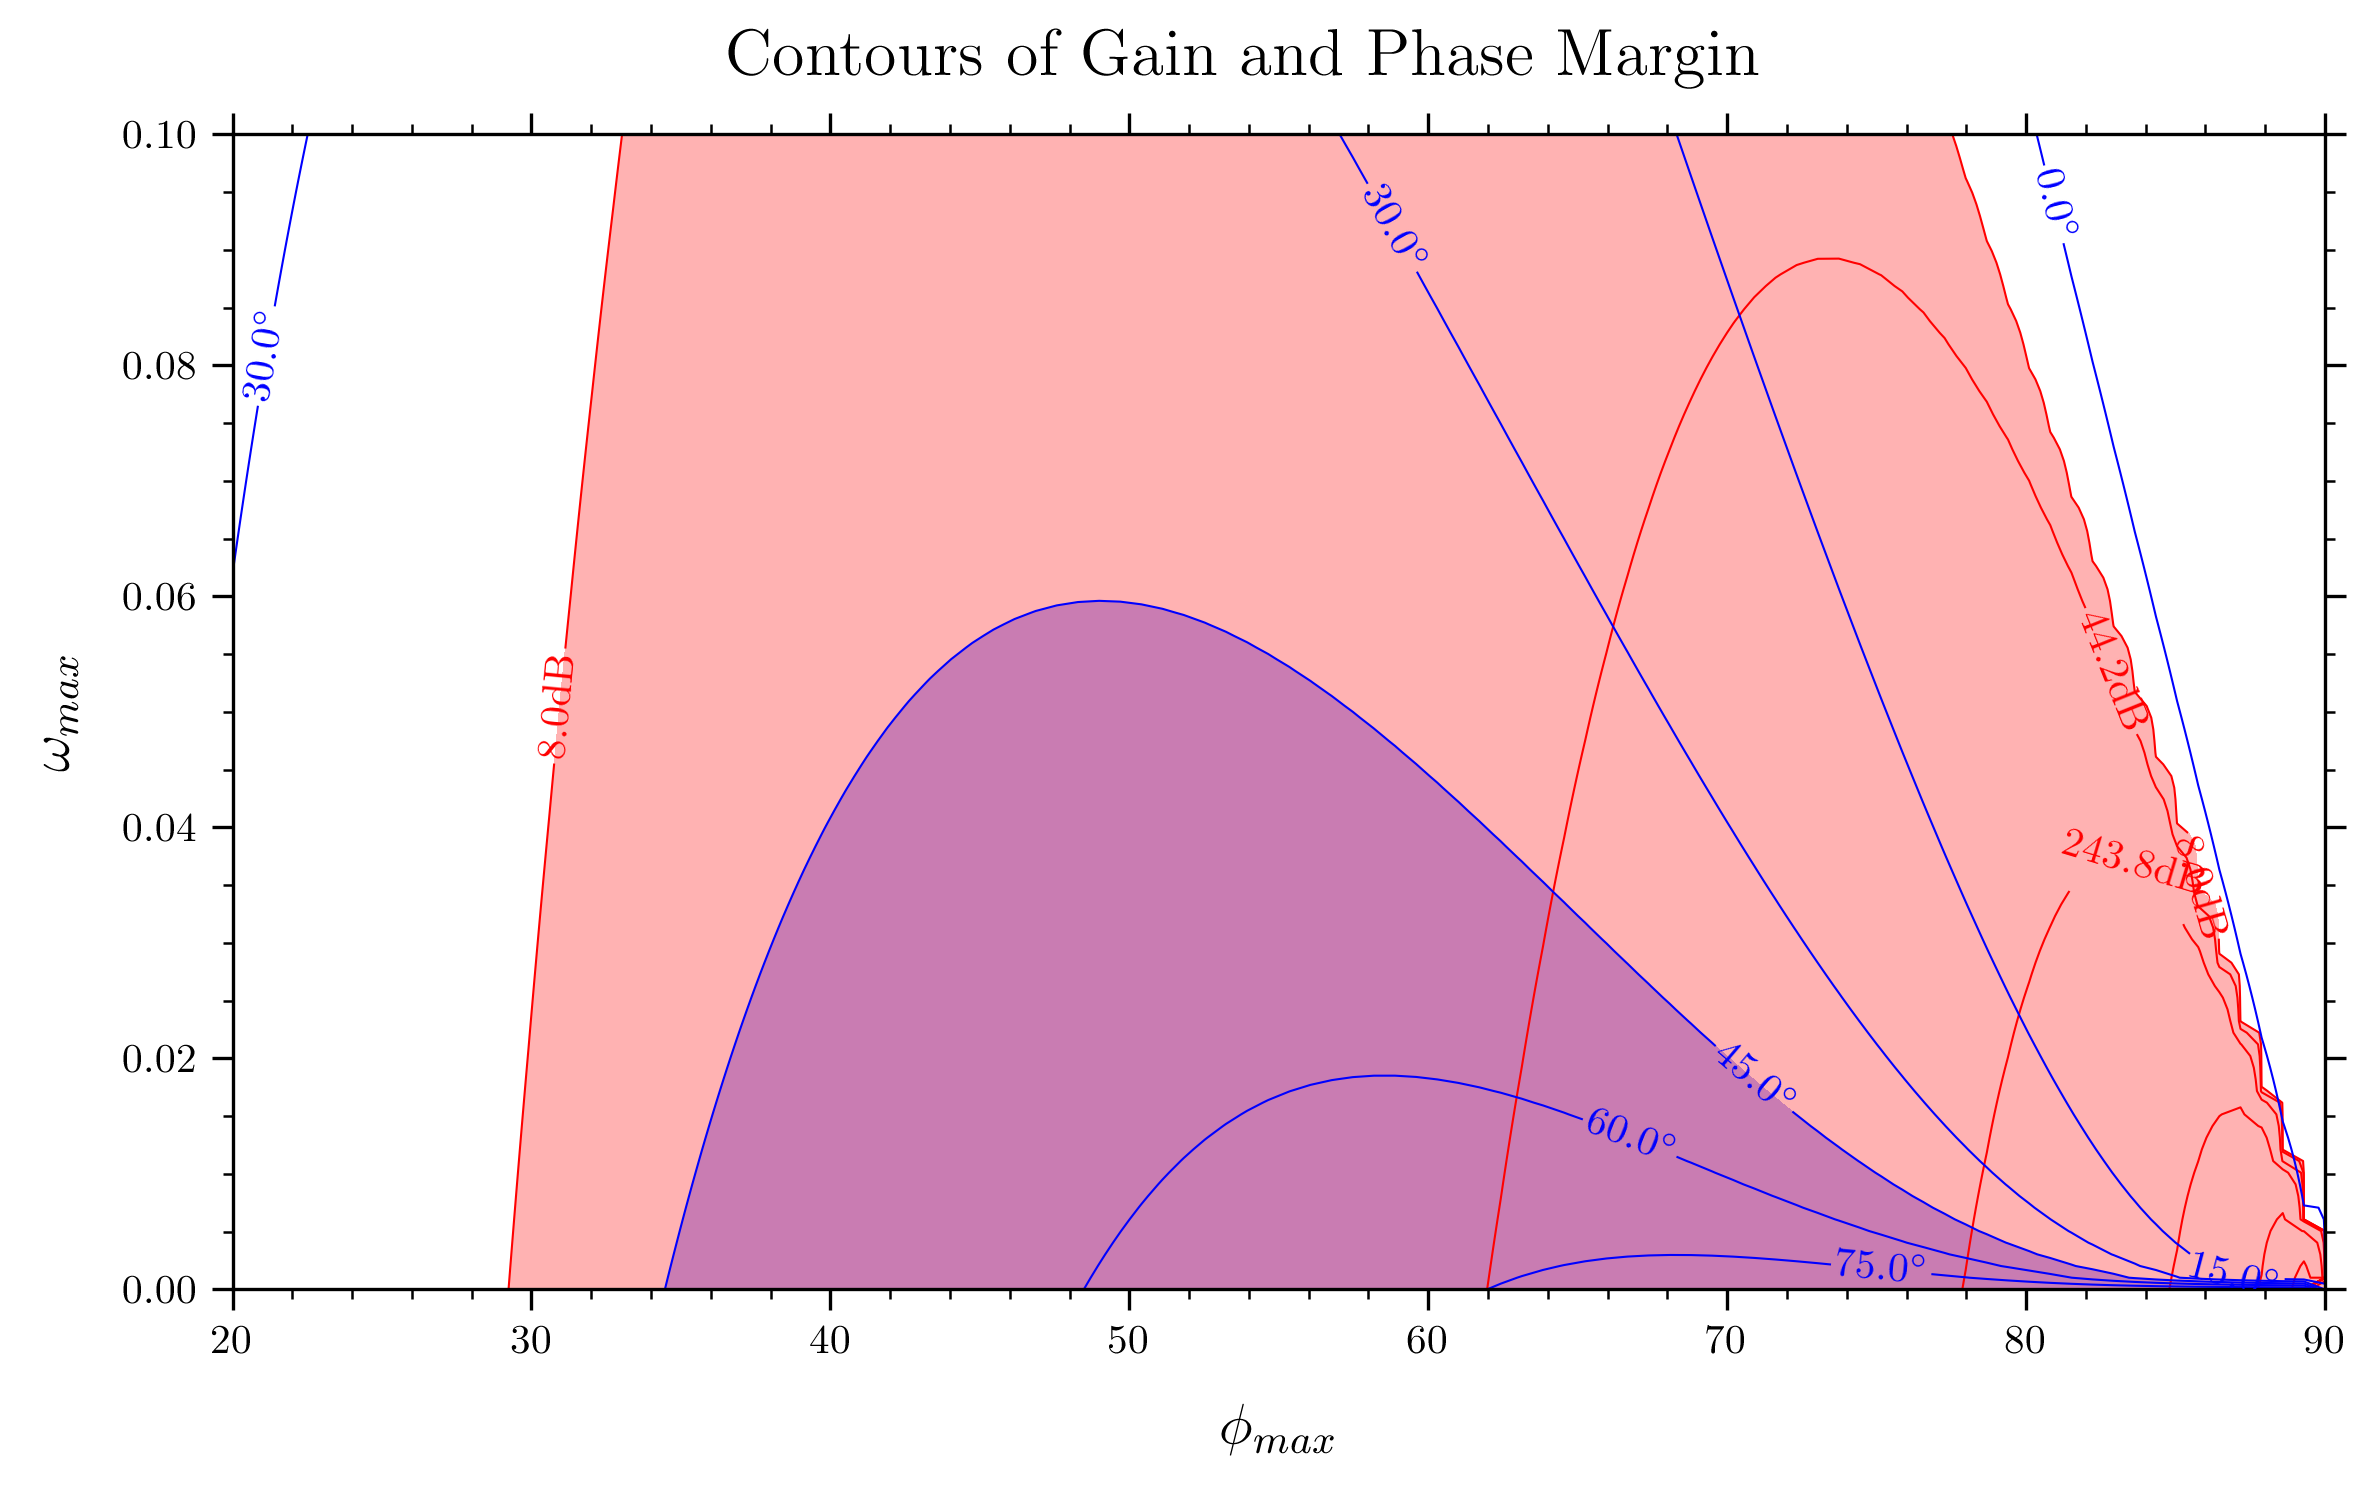

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(9,5), dpi=300)
CS = ax.contour(phi_max, w_c, gm_array, colors='r', linewidths=0.5, \
    extent=[phi_max.min(), phi_max.max(), w_c.min(), w_c.max()], \
    levels=np.logspace(np.log10(8), 15, 20))
ax.clabel(CS, inline=1, fontsize=10, fmt=lambda x: f'{x:.1f}dB')
CS = ax.contour(phi_max, w_c, pm_array, colors='b', linewidths=0.5, \
    extent=[phi_max.min(), phi_max.max(), w_c.min(), w_c.max()])
ax.clabel(CS, inline=1, fontsize=10, fmt=lambda x: f'{x:.1f}$^\circ$')
# CS = ax.contour(phi_max, w_c, os_array, colors='k', linewidths=0.5, \
#     extent=[phi_max.min(), phi_max.max(), w_c.min(), w_c.max()], \
#     levels=np.linspace(0, 30, 5))
# ax.clabel(CS, inline=1, fontsize=10, fmt=lambda x: f'{x:.2f}')
# CS = ax.contour(phi_max, w_c, Ts_array, colors='g', linewidths=0.5, \
#     extent=[phi_max.min(), phi_max.max(), w_c.min(), w_c.max()], \
#     levels=[6.117310889326277])
# ax.clabel(CS, inline=1, fontsize=10, fmt=lambda x: f'{x:.2f}')

# fill the contours, which have pm>45 and gm>8
ax.contourf(phi_max, w_c, pm_array, colors='b', \
    extent=[phi_max.min(), phi_max.max(), w_c.min(), w_c.max()], \
        levels=[45, 100], alpha=0.3)
ax.contourf(phi_max, w_c, gm_array, colors='r', \
    extent=[phi_max.min(), phi_max.max(), w_c.min(), w_c.max()], \
        levels=[8, 1e25], alpha=0.3)

ax.set_xlabel(r'$\phi_{max}$', fontsize=14, labelpad=10)
ax.set_ylabel(r'$\omega_{max}$', fontsize=14, labelpad=10)
fig.suptitle('Contours of Gain and Phase Margin', fontsize=16, y=0.95)
fig.savefig("contour_gm_pm.jpg", bbox_inches='tight')
plt.show()